This notebook deals with single node percolation. It shows that following the cascade of knokouts is equivalent to run the dynamics for the indicator variables of the out-component

In [1]:
import numpy as np
%matplotlib inline
import sys
sys.path.insert(0, "../lib")# add the library folder to the path I look for modules
from directed_random_graph import *# this is the function I wrote
from multiprocessing import Pool
import itertools
import pickle
from scipy.optimize import fsolve,root
import component as co
from timeit import default_timer as timer
import latexify# execute function latexify for plots coherent with latex
from networkx.algorithms import bipartite
import component as cp
import scipy
import time #to measure performances
def save_obj(obj, name ):
    with open('dic-'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name,path = '.'):
    with open(path+'/dic-' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def filter_SCC(BG,Genes):
        '''It extract the SCC subgraph'''
        Gc=cp.maximum_strongly_connected_component_subgraph(BG)
        Gc_G=set(Gc.nodes()).intersection(Genes)# set of genes in the giant cluster
        Genes=[n for n,d in Gc.nodes(data=True) if d['bipartite']==0]
        N1=len(Genes)
        TFs=[n for n,d in Gc.nodes(data=True) if d['bipartite']==1]
        N2=len(TFs)
        eta=bipartite.biadjacency_matrix(Gc,Genes)#from genes  to TF
        xi=bipartite.biadjacency_matrix(Gc,TFs)#from  TF to  genes
        in_deg=scipy.sparse.csr_matrix(list(dict(Gc.in_degree(TFs)).values()))
        return Genes,TFs,eta,xi,in_deg


module loaded at  2022-01-04 15:38:20.732840


## Out-component propagation
Propagation of eliminated nodes. It computes the nodes that do not belong to out-component as a consequence of the elimination of a single node.
Core function is *propagate_nonlinear(BG,Genes,TFs,node)*


*Input*: 
- BG: bipartite graph (should already be the SCC)
- Genes: set of Genes
- TFs: set of Trascription factors
- node: one element of Genes


*Returns*:
filtered graph.

 It start off from a node(gene2remove) and consider its succesors ( TF2remove) which is removed. Genes that are not regulated, i.e. their in degree is 0, are removed.  The procedure is repeated until there is no new gene to be removed.

Algorithm:
- The SCC is computed
- for each node in SCC
    - *propagate_nonlinear*  function is executed on the SCC and return a filtered graph.
    - compute $g$, the fraction of genes in the filtered graph over the SCC 
- histogram of $g$ over different sites, the relative ratio $$ \dfrac{count[  g\sim 1]}{count[  g\sim 0]+count[  g\sim 1]} $$ is shown in heatmap.
It  is a stability measure, i.e. the fraction of initial conditions that do no lead to an elimination cascade.
### remove_dynamics
I compare *propagate_nonlinear* with the non linear dynamics on the same graph where 'node' is imposed to be off at all times. They gives the same result

In [2]:
def remove_dynamics(eta,xi,in_deg,node,process=0):
    N1=eta.shape[0]
    def time_step_on(n,n_start):
        m=np.where((n*eta!=in_deg).toarray(),0,1)
        n=scipy.sparse.csr_matrix(m)*xi
        n=np.where(n.toarray()>0,1,0)
        n[0][n_start==0]=0# enforce elimination constrain of Genes initially eliminated
        n=scipy.sparse.csr_matrix(n)
        return n,m # it is in the array format
    t=0
    n_start=np.ones(N1)
    n_start[node]=0
    n=scipy.sparse.csr_matrix(n_start)
    N_iter=1000
    while t< N_iter:
        n_new,m=time_step_on(n,n_start)
        if n_new.nnz==n.nnz:
            if all(n_new.indices==n.indices):# exit if no improvements occur
                break
        n=n_new
        t+=1
    return n.toarray()[0],m[0]

    
def propagate_nonlinear(BG,Genes,TFs,node):
    '''
    Input:
    node: is the id of the node to be eliminated. It has to be a gene, otherwise ValueError is raised.
    Algorithm:
        Node is eliminated, then the successors of the node are eliminated. If then  genes are not regulated, than they are eliminated as well. 

    '''
    BG_filtered=BG.copy()
    #BG_tf=dict(BG.in_degree(TFs))# dictionary of in degree for TF in the original bipartite graph
    count=0
    if node not in Genes:
        raise ValueError("starting point should be a Gene")
    genes2remove=[node]
    while True:
        
        #print(count)
        '''
        TF2remove=set(flatten([list(BG_filtered.successors(n)) for n in genes2remove]))#TF successor of a gene have to be eliminated
        BG_filtered.remove_nodes_from(genes2remove)
        genes_potentially_rm=set(flatten([list(BG_filtered.successors(n)) for n in TF2remove]))
        genes2remove=[n for n,k in dict(BG_filtered.in_degree(genes_potentially_rm)).items() if k ==1]#if a gene  is reached only by TF2remove 
        BG_filtered.remove_nodes_from(TF2remove)'''
        
        TF2remove=set(flatten([list(BG_filtered.successors(n)) for n in genes2remove]))#TF successor of a gene have to be eliminated
        BG_filtered.remove_nodes_from(genes2remove+list(TF2remove))
        genes2remove=[n for n,k in dict(BG_filtered.in_degree(Genes)).items() if k ==0]
        #print(len(Gc),len(BG_filtered))
        if len(genes2remove)==0:
            #print("number of deletion iteration",count)
            return BG_filtered
        count+=1


def out_statistics(eta,xi,in_deg,node):
    
    n,m=remove_dynamics(eta,xi,in_deg,node)    
    return [np.count_nonzero(n>0)/len(n), np.count_nonzero(m>0)/len(m)]
def out_statistics2(BG,Genes,TFs,node):
    SG=propagate_nonlinear(BG,Genes,TFs,node)
    filtered_Genes = set(SG.nodes()).intersection(Genes)
    filtered_TFs = set(SG.nodes()).intersection(TFs)
    return [len(filtered_Genes)/len(Genes), len(filtered_TFs)/len(TFs)]
def filter_SCC(BG,Genes):
        '''It extract the SCC subgraph'''
        Gc=maximum_strongly_connected_component_subgraph(BG)
        Gc_G=set(Gc.nodes()).intersection(Genes)# set of genes in the giant cluster
        Genes=[n for n,d in Gc.nodes(data=True) if d['bipartite']==0]
        N1=len(Genes)
        TFs=[n for n,d in Gc.nodes(data=True) if d['bipartite']==1]
        N2=len(TFs)
        eta=bipartite.biadjacency_matrix(Gc,Genes)#from genes  to TF
        xi=bipartite.biadjacency_matrix(Gc,TFs)#from  TF to  genes
        in_deg=scipy.sparse.csr_matrix(list(dict(Gc.in_degree(TFs)).values()))
        return Genes,TFs,eta,xi,in_deg

def create_graph_and_remove(N1,N2,d,c):

    _,BG=create_bipartite(N1,N2,d,c)
    Genes= np.arange(0,N1)
    pool = Pool()
    Genes,TFs,eta,xi,in_deg=filter_SCC(BG,Genes)
    data=pool.starmap(out_statistics,itertools.product([eta],[xi],[in_deg],random.sample(range(len(Genes)),min(len(Genes),1000))))#knockout 1000 genes at the most
    #data=pool.starmap(out_statistics,itertools.product([eta],[xi],[in_deg],range(len(Genes))))
    pool.close()

    return data
def create_graph_and_remove2(N1,N2,d,c):
    def filter_SCC(BG,Genes):
        #It extract the SCC subgraph
        Gc=maximum_strongly_connected_component_subgraph(BG)
        Gc_G=set(Gc.nodes()).intersection(Genes)# set of genes in the giant cluster
        Genes=[n for n,d in Gc.nodes(data=True) if d['bipartite']==0]
        N1=len(Genes)
        TFs=[n for n,d in Gc.nodes(data=True) if d['bipartite']==1]
        N2=len(TFs)
        eta=bipartite.biadjacency_matrix(Gc,Genes)#from genes  to TF
        xi=bipartite.biadjacency_matrix(Gc,TFs)#from  TF to  genes
        in_deg=scipy.sparse.csr_matrix(list(dict(Gc.in_degree(TFs)).values()))
        return Genes,TFs,eta,xi,in_deg

    _,BG=create_bipartite(N1,N2,d,c)
    TFs=arange(N1,N1+N2)
    Genes=arange(0,N1)
    pool = Pool()
    Genes,TFs,_,_,_=filter_SCC(BG,Genes)
    Gc=maximum_strongly_connected_component_subgraph(BG)
    data=pool.starmap(out_statistics2,itertools.product([Gc],[Genes],[TFs],random.sample(Genes,min(len(Genes),1000))))#knochout 1000 genes to the most
    #data=[out_statistics2(Gc,Genes,TFs,node)for node in Genes]
    pool.close()

    return data


Comparison between dynamics and propagation on network

In [3]:
d=2
c=1
N1=10000
N2=10000
TFs=np.arange(N1,N1+N2)
Genes=np.arange(0,N1)
_,BG=create_bipartite(N1,N2,d,c)
Gc=maximum_strongly_connected_component_subgraph(BG).copy()
Gc_G=set(Gc.nodes()).intersection(Genes)# set of genes in the giant cluster
node=random.choice(list(Gc_G))
Genes,TFs,eta,xi,in_deg=filter_SCC(Gc,Genes)

In [4]:
np.mean(list(dict(BG.in_degree(TFs)).values()))

2.969315132423288

In [5]:
start_time = time.time()
pool = Pool()
data=pool.starmap(out_statistics,itertools.product([eta],[xi],[in_deg],random.sample(range(len(Genes)),min(len(Genes),1000))))#knockout 1000 genes at the most
pool.close()
print("--- %s seconds ---" % (time.time() - start_time))
pool = Pool()
start_time = time.time()
data2=pool.starmap(out_statistics2,itertools.product([Gc],[Genes],[TFs],random.sample(Gc_G,min(len(Gc_G),1000))))#knochout 1000 genes to the most
pool.close()
print("--- %s seconds ---" % (time.time() - start_time))


--- 3.750331401824951 seconds ---


NameError: name 'flatten' is not defined

In [18]:
#A=propagate_nonlinear(Gc,Genes,TFs,node).nodes()
#print(len(A))
#B=remove_dynamics(eta,xi,in_deg,node)
#nodes_B=set(Genes[where(B[0][0]>0,True,False)]).union(TFs[where(B[1][0]>0,True,False)])
start_time = time.time()
B=array([out_statistics(eta,xi,in_deg,node) for node in arange(len(Genes))])
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
A=array([out_statistics2(Gc,Genes,TFs,node)for node in Genes])
print("--- %s seconds ---" % (time.time() - start_time))


--- 7.015820264816284 seconds ---
--- 13.85520601272583 seconds ---


Two methods give the very same result, and the parallel version is faster

In [7]:
print("non linear dynamics and `propagate` give the same result?",any(A==B))

NameError: name 'A' is not defined

In [175]:
ratio=[]
for i in range(5000):
    data=array(create_graph_and_remove(N1,N2,d,c))
    ratio+=[np.count_nonzero(data[:,0]>0.5)/len(data)]

Load the dictionary instead than executing

In [84]:
dic=load_obj("repetion_elimination")
ratio=dic['ratio']
N1=dic['N1']
N2=dic['N2']
c=dic['c']
d=dic['d']


dict_keys(['d', 'c', 'N1', 'N2', 'g', 'Nrep', 'description'])


KeyError: 'ratio'

In [98]:
dic=load_obj("c:1.0 d:2.0",'knockout-cascade_multiple')
data =np.array(dic['g'])
np.count_nonzero(data,axis = 1)


266.0

Repeating the experiment, the fraction of nodes triggering an elimination cascade changes

/home/giuseppe/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


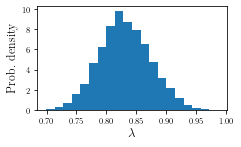

In [9]:
latexify.latexify(columns = 2)
#title("N="+str(N1)+" c= "+str(c)+" d= "+str(d))
plt.hist(ratio,20,density=True)
plt.xlabel("$\\lambda$",fontsize=13)
plt.ylabel("Prob. density",fontsize=12)
plt.tight_layout()
#plt.savefig("repetition_elimination.pdf")

In [31]:
dic={"ratio":ratio,"N1":N1,"N2":N2,"c":c,"d":d}
#save_obj(dic,"repetion_elimination")

In [132]:
#dic=load_obj("repetion_elimination")


dict_keys(['lambda', 'ds', 'cs', 'N1', 'N2'])

In [100]:
d=2
c=1
N1=10000
N2=10000
TFs=np.arange(N1,N1+N2)
Genes=np.arange(0,N1)
_,BG=create_bipartite(N1,N2,d,c)
#Gc=maximum_strongly_connected_component_subgraph(BG).copy()
BG_G=set(BG.nodes()).intersection(Genes)# set of genes in the giant cluster
#Genes,TFs,eta,xi,in_deg=filter_SCC(Gc,Genes)
eta=bipartite.biadjacency_matrix(BG,Genes)#from genes  to TF
xi=bipartite.biadjacency_matrix(BG,TFs)#from  TF to  genes
in_deg=scipy.sparse.csr_matrix(list(dict(BG.in_degree(TFs)).values()))

pool = Pool()
data=np.array(pool.starmap(out_statistics,itertools.product([eta],[xi],[in_deg],range(len(Genes)))))
#data=array(pool.starmap(out_statistics,itertools.product([eta],[xi],[in_deg],random.sample(range(len(Genes)),min(len(Genes),1000)))))#knockout 1000 genes at the most
pool.close()

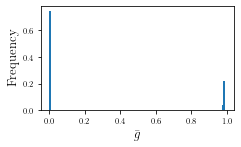

In [123]:
latexify.latexify(columns=2)
h0,b0=np.histogram(np.array(data)[:,0],bins=np.arange(0.,1,0.01),density = False)
plt.bar(b0[:-1],h0/(np.sum(h0)),np.diff(b0),align='edge')
plt.xlabel("$\\bar{g}$",fontsize=13)
plt.ylabel("Frequency",fontsize=13)
plt.tight_layout()
#plt.savefig("elimination_nonlinear.pdf")


In [112]:
h1/(np.sum(h0)*(np.diff(b0)[0]))

99.99000000000001

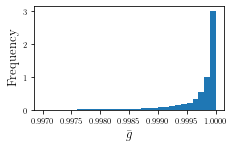

In [122]:
h1,b1=np.histogram(np.array(data)[:,0],bins=np.arange(0.997,1,1/N1))
plt.bar(b1[:-1],h1/(np.sum(h0)),np.diff(b1),align='edge')
plt.xlabel("$\\bar{g}$",fontsize=13)
plt.ylabel("Frequency",fontsize=13)
plt.tight_layout()
#plt.savefig('elimination_inset.pdf')

I now look at $g$ around 1, I consider the number of genes that do not belong to aOC  as a result of the single gene elimination. The node that was initially eliminated  is not counted.

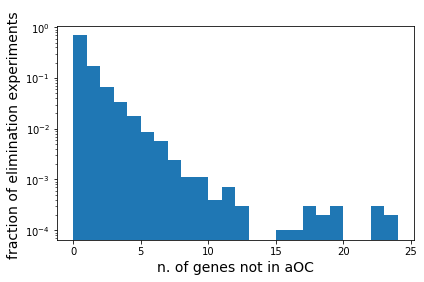

In [69]:
x=array(data)[:,0]
g=numpy.round((1-x[x>0.5])*len(Genes))
h,b=histogram(g,bins=arange(min(g),max(g)+2))
bar(b[:-1]-1,h/sum(h),diff(b),align='edge')# -1 accounts for the gene that was initially eliminated
xlabel("n. of genes not in aOC",fontsize=14)
ylabel("fraction of elimination experiments ",fontsize=14)
#title("c="+str(c)+" d="+str(d))
semilogy()
tight_layout()
#savefig("genes_knocked_out.png")

## Create heatmap for $\lambda$

In [58]:
ds = np.linspace(0.001,4,50)
cs = np.linspace(0.001,2,30)
lambda_heat =[]
for d in ds:
    for c in cs:
        data=np.array(create_graph_and_remove(N1,N2,d,c))
        lambda_heat+=[np.count_nonzero(data[:,0]>0.5)/len(data)]

In [60]:
dic = {'lambda':np.array(lambda_heat).reshape((len(ds),len(cs))),'ds':ds,'cs':cs,'N1':N1,'N2':N2}
#save_obj(dic,'lambda_heatmap')

In [6]:
dic = load_obj('lambda_heatmap')
#dic = load_obj('lambda_heatmap_c_2.0_d_3.0')

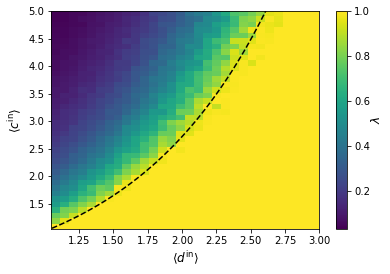

In [8]:
plt.imshow(dic['lambda'],aspect = 'auto', extent=(1+min(dic['cs']),1+max(dic['cs']),1+min(dic['ds']),1+max(dic['ds'])),origin='lower')
plt.xlabel("$\langle d^{\\mathrm{in}}\\rangle$",fontsize = 12)
plt.ylabel("$\langle c^{\\mathrm{in}}\\rangle$",fontsize = 12)
x = np.linspace(1,3,100)
plt.plot(x,np.exp(x-1),'k--')
plt.ylim(1+min(dic['ds']),1+max(dic['ds']))
plt.xlim(1+min(dic['cs']),1+max(dic['cs']))

cbar = plt.colorbar()
cbar.set_label("$\\lambda$",rotation=90,fontsize=12,labelpad=0)

In [3]:
g=(1-x[x>0.5])*len(Genes)
h,b=histogram(g,bins=arange(min(g),max(g)+2))
r,t=unique(g,return_counts=True)
#print(b,h)

NameError: name 'x' is not defined

In [7]:
g = []
for i in range(3):
    data = array(create_graph_and_remove(N1, N2, d, c))
    x = array(data)[:, 0]
    g += [numpy.round((1 - x[x > 0.5]) * len(Genes))]


In [94]:
bs=[]
hs=[]
for i in range(3):
    h,b=histogram(g[i],bins=arange(1,max(flatten(g))))
    hs+=[h]
    bs+=[b]

[]

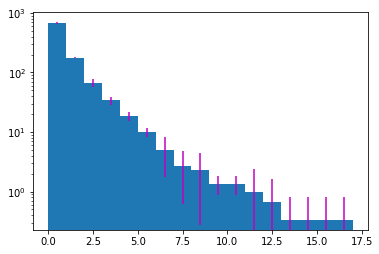

In [130]:
x=bs[0]-1
bar((x[:-1]+x[1:])/2,mean(hs,axis=0),diff(bs[0]))
errorbar((x[:-1]+x[1:])/2,mean(hs,axis=0),yerr=std(hs,axis=0),ecolor='m',fmt='none')
semilogy()

In [134]:
len(x)

1000

h

# Repetition over different networks

In [2]:
def remove_dynamics(eta,xi,in_deg,node):
    N1=eta.shape[0]
    def time_step_on(n,n_start):
            m=np.where((n*eta!=in_deg).toarray(),0,1)
            n=scipy.sparse.csr_matrix(m)*xi
            n=np.where(n.toarray()>0,1,0)
            n[0][n_start==0]=0# enforce elimination constrain of Genes initially eliminated
            n=scipy.sparse.csr_matrix(n)
            return n,m # it is in the array format
    t=0
    n_start=ones(N1)
    n_start[node]=0
    n=scipy.sparse.csr_matrix(n_start)
    N_iter=1000
    while t< N_iter:
            n_new,m=time_step_on(n,n_start)
            if n_new.nnz==n.nnz:
                if all(n_new.indices==n.indices):# exit if no improvements occur
                    break
            n=n_new
            t+=1
    return n.toarray()[0]


def create_graph_and_remove(N1,N2,d,c):

    _,BG=create_bipartite(N1,N2,d,c)
    Genes=arange(0,N1)
    pool = Pool()
    Genes,TFs,eta,xi,in_deg=filter_SCC(BG,Genes)
    data=pool.starmap(remove_dynamics,itertools.product([eta],[xi],[in_deg],range(len(Genes))))#knockout 1000 genes at the most
    #data=pool.starmap(out_statistics,itertools.product([eta],[xi],[in_deg],range(len(Genes))))
    pool.close()

    return data   

In [7]:
N1=2000
N2=N1
d=1
c=2
Nrepetions=1000
data=[create_graph_and_remove(N1,N2,d,c) for i in range(Nrepetions)]# this is a matrix,  

Process ForkPoolWorker-245:
Process ForkPoolWorker-247:
Process ForkPoolWorker-248:
Process ForkPoolWorker-246:
Process ForkPoolWorker-244:
Process ForkPoolWorker-242:
Process ForkPoolWorker-243:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap

KeyboardInterrupt: 

Process ForkPoolWorker-255:
Process ForkPoolWorker-264:
Process ForkPoolWorker-262:
Process ForkPoolWorker-260:
Process ForkPoolWorker-250:
Process ForkPoolWorker-261:
Process ForkPoolWorker-259:
Process ForkPoolWorker-256:
Process ForkPoolWorker-254:
Process ForkPoolWorker-257:
Process ForkPoolWorker-258:
Traceback (most recent call last):
Process ForkPoolWorker-252:
Traceback (most recent call last):
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-263:
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.

  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/k1762355/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/k1762355/anaconda3/l

In [ ]:
dic={'data':data,'Nrepetitions':Nrepetions,'description':'data is a tensor with 3 indices. The first index is the repetition considered, the other two indeces are for the matrix of knockout experiment.Call A this matrix, A[i,j] is whether node j is in the giant component as a result of knockout of gene i. '}
save_obj(dic,'knockout_repetions-d:'+str(d)+',c:'+str(c))

data is a matrix such that row $i$ is the outcome of the elimination of gene $i$.data[i,j] indicates whether gene j belongs to the giant component when i is eliminated

In [9]:
dic=load_obj('knockout_repetions-d:'+str(d)+',c:'+str(c))

UnpicklingError: pickle data was truncated

## Giant cluster resilient to percolation
This is a different problem, a node in SCC is eliminated, than the new set of nodes that form a SCC is selected and so on.
Linear and non-linear SCC are investigated here
### Protocol 1
I eliminate a Gene from linear SCC and verify what is the size of SCC.
SCC non linear is computed by doing iteratively:
- SCC
- remove TF whose in degree has changed

In [2]:
def remove_nonlinear(BG,Genes,TFs,node,process=0):
    '''Return the subgraph in the SCC, and then removes TFs whose in degree is not the same as initially. Graph is perturbed by removing one random node in SCC linear '''
    BG_filtered=BG.copy()
    BG_tf=dict(BG.in_degree(TFs))# dictionary of in degree for TF in the bipartite graph
    count=0
    # Initially remove one node from the strongly connected component, I choose this node among those in SCC
    BG_filtered.remove_node(node)
    
    while True:
        Gc=maximum_strongly_connected_component_subgraph(BG_filtered)
        #print(len(Gc),len(BG_filtered))
        #print(BG_filtered.nodes())
        if len(Gc)==len(BG_filtered):
            #print("number of deletion iterations:",count)
            return BG_filtered
        count+=1
        
        Gc_G=set(Gc.nodes()).intersection(Genes)# set of genes in the giant cluster
        Gc_tf=dict(Gc.in_degree(TFs))# dictionary of in degree for TF in the SCC
        filtered={v for v,k in Gc_tf.items() if BG_tf[v]==k} # filtered dictionary of SCC if TF has same indegree as initially
        #BG_filtered.remove_nodes_from([n for n in BG_filtered if n not in set(filtered).union(Gc_G)])#remove TFs with wrond in-degree and Genes not in SCC
        BG_filtered=BG_filtered.subgraph(set(filtered).union(Gc_G)).copy()
        #print(set(filtered),Gc_G)
def remove_linear(BG,Genes,TFs,node,process=0):
    BG_filtered=BG.copy()
    # Initially remove one node from the strongly connected component, I choose this node among those in SCC
    BG_filtered.remove_node(node)
    Gc=maximum_strongly_connected_component_subgraph(BG_filtered)
    return Gc
def SCC_statistics(BG,node,linear):
    '''Returns the fraction of nodes respect to the entire graph'''
    Genes=[n for n,d in BG.nodes(data=True) if d['bipartite']==0]
    N1=len(Genes)
    TFs=[n for n,d in BG.nodes(data=True) if d['bipartite']==1]
    N2=len(TFs)
    if linear:
        SG=remove_linear(BG,Genes,TFs,node)
    else:
        SG=remove_nonlinear(BG,Genes,TFs,node)
    filtered_Genes = set(SG.nodes()).intersection(Genes)
    filtered_TFs = set(SG.nodes()).intersection(TFs)
    return [len(filtered_Genes)/N1, len(filtered_TFs)/N2]
def create_graph_and_remove(N1,N2,d,c,linear=False):

    _,BG=create_bipartite(N1,N2,d,c)
    TFs=arange(N1,N1+N2)
    Genes=arange(0,N1)
    Gc=maximum_strongly_connected_component_subgraph(BG)
    Gc_G=set(Gc.nodes()).intersection(Genes)# set of genes in the giant cluster
    pool = Pool()
    data=pool.starmap(SCC_statistics,itertools.product([BG],Gc_G,[linear]))
    #data=pool.starmap(SCC_statistics,itertools.product([BG],set(Genes).difference(set(Gc.nodes()))))# here I eliminate an inoffencive node
    pool.close()

    return data

def save_obj(obj, name ):
    with open('dic-'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
  

In [4]:
d=0.5
c=0.5
N1=1000
N2=1000
data=create_graph_and_remove(N1,N2,d,c,linear=True)

rather than normalising to the nodes in the graph, I normalise w.r.t. number of nodes in SCC. By "elimination experiment" I mean the protocol where I remove one node and check what is the fraction of nodes that remains in SCC

Text(0,0.5,'fraction of elimination experiments ')

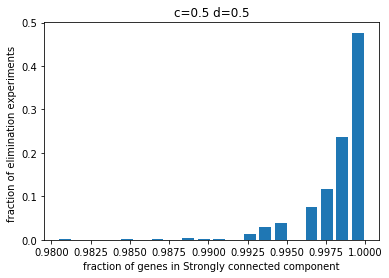

In [5]:
title("c="+str(c)+" d="+str(d))
h,b=histogram(array(data)[:,0],20)
bar((b[1:]+b[:-1])/2*N1/(sum(h)-1),h/sum(h),diff(b))#sum(h) is the number of nodes in SCC, -1 because I have removes a node in the graph 
xlabel("fraction of genes in Strongly connected component")
ylabel("fraction of elimination experiments ")
#savefig("elimination_linear.pdf")

In [34]:
h,b=histogram(array(data)[:,0],20)
h

array([  1,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,  11,
         0,   0,   0,  85,   0,   0, 873])

In [59]:
d=3
c=2
N1=3000
N2=3000
data=create_graph_and_remove(N1,N2,d,c,linear=False)

TypeError: create_graph_and_remove() got an unexpected keyword argument 'linear'

In [ ]:
title("c="+str(c)+" d="+str(d))
h,b=histogram(array(data)[:,0],20)
bar((b[1:]+b[:-1])/2*N1/(sum(h)-1),h/sum(h),diff(b))#sum(h) is the number of nodes in SCC, -1 because I have removes a node in the graph 
xlabel("fraction of genes in Strongly connected component")
ylabel("fraction of elimination experiments ")
#savefig("elimination_nonlinear.pdf")

In [20]:
dic={"d":d,"c":c,"N1":N1,"data":data}
#save_obj(dic,"knockout")

we conclude that elimination procedure for linear SCC is stable, i.e. node elimination does not break down the network.
## Experiment 2
I now compare the effect of single gene knockout over different networks. I always compute the strongly connected component non linear

In [3]:
N1=1000
N2=1000
p=[]
c=1
ds=linspace(0.5,5,10)
for d in ds:
        data=create_graph_and_remove(N1,N2,d,c)
        h,b=histogram(array(data)[:,0],20)
        p+=[h[-1]/(h[0]+h[-1])]


Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/giuseppe/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/giuseppe/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/giuseppe/miniconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/giuseppe/miniconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/giuseppe/miniconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/giuseppe/miniconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/giuseppe/miniconda3/lib/python3.

KeyboardInterrupt: 

Process ForkPoolWorker-11:
Process ForkPoolWorker-9:
Process ForkPoolWorker-12:
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/giuseppe/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/giuseppe/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/giuseppe/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/giuseppe/miniconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/giuseppe/miniconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/giuseppe/miniconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/giuseppe/miniconda3/lib/python3.7/mul

Text(0.5,1,'c=1')

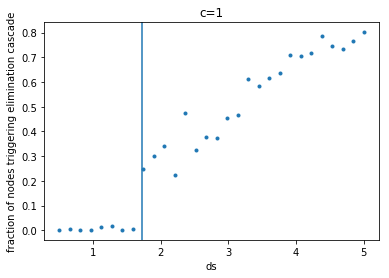

In [153]:
plot(linspace(0.5,5,30),1-array(p),".")
axvline(exp(c)-1)
xlabel("ds")
ylabel("fraction of nodes triggering elimination cascade")
title("c="+str(c))

In [ ]:
N1=1000
N2=1000
data=[]
c=1
ds=linspace(0.5,5,30)
for d in ds:
    p=[]
    for i in range(100):# mediate over 100 graphs
        data=create_graph_and_remove(N1,N2,d,c)
        h,b=histogram(array(data)[:,0],20)
        p+=[h[-1]/(h[0]+h[-1])]
    data+=[p]

/home/k1762355/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()



Load simulation result

In [6]:
def d_critical(ds,c,alpha,p,up):
    if up:
        f=fon
    else:
        f=foff
    num=[]
    status=[]
    for d in ds:
        if up:
            sol=root(f,1,args=(c,d,alpha,p))
        else:
            sol=root(f,0,args=(c,d,alpha,1.-p))
        num+=[sol.x]
        status+=[sol.success]
    num=squeeze(array(num))
    status=squeeze(array(status))
    
    if up:
        d=ds[status&(num<1)&(num>0)][-1]# return the highest d the transistion happen
        if d==ds[-1]:
            warnings.warn("Adjust the boundaries of ds")
            return d_critical(linspace(max(ds),max(ds)+4,100),c,alpha,p,up)
        return d 
    else:
        return ds[status&(num<1)&(num>0)][0]# return the lowest d
def fon(g,c,d,alpha,p):
    return exp(-(c*g*p*alpha*exp((d*(-1 + g))/alpha)))*(-1 + g*p*exp((d*(-1 + g))/alpha) + exp(c*g*p*alpha*exp((d*(-1 + g))/alpha)))-g


In [12]:
def load_obj(name,prefix="./" ):
    with open(prefix+'dic-' + name + '.pkl', 'rb') as f:
        return pickle.load(f)




No handles with labels found to put in legend.


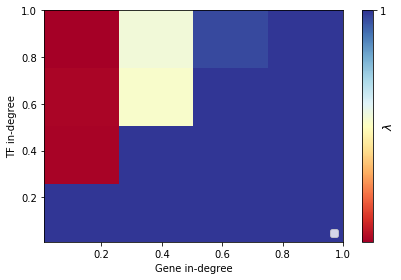

In [14]:
m=load_obj("SCC_propagation")["m"]
ds=load_obj("SCC_propagation")["ds"]
cs=load_obj("SCC_propagation")["cs"]
imshow(m, origin="lower",extent=(cs[0],cs[-1],ds[0],ds[-1]),aspect="auto",cmap='RdYlBu')
cbar=colorbar()
xlabel("Gene in-degree")
ylabel("TF in-degree")
alpha=1
#plot(cs,(-1 +exp(cs*alpha) )*alpha+(alpha-1)*where(alpha<1,1,0),"m",lw=2) # for d larger then this,the state with n=1 becomes instable
ylim(ds[0],ds[-1])
#plot(cs,[d_critical(linspace(min(ds),max(ds),100),c,alpha,1-1/10000,True) for c in cs],"m--",lw=3,label="cavity")
cbar.set_label("$\\lambda$",rotation=90,fontsize=12,labelpad=-5)
cbar.set_ticks([0,1])
cbar.patch.set_facecolor("none")
legend(loc="lower right")
tight_layout()
#savefig("SCC_prop.pdf")
#xlim(0.5,1)
#ylim(0.5,1)

In [24]:
ds

array([0.01      , 0.12512821, 0.24025641, 0.35538462, 0.47051282,
       0.58564103, 0.70076923, 0.81589744, 0.93102564, 1.04615385,
       1.16128205, 1.27641026, 1.39153846, 1.50666667, 1.62179487,
       1.73692308, 1.85205128, 1.96717949, 2.08230769, 2.1974359 ,
       2.3125641 , 2.42769231, 2.54282051, 2.65794872, 2.77307692,
       2.88820513, 3.00333333, 3.11846154, 3.23358974, 3.34871795,
       3.46384615, 3.57897436, 3.69410256, 3.80923077, 3.92435897,
       4.03948718, 4.15461538, 4.26974359, 4.38487179, 4.5       ])

Text(0.5,1,'c=1.0315384615384617')

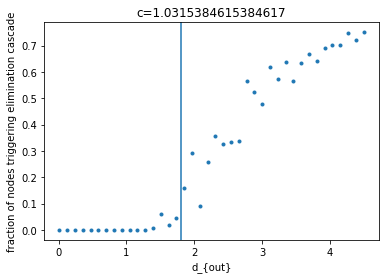

In [15]:
i=16
axvline(exp(cs[i])-1)
xlabel("ds")
ylabel("fraction of nodes triggering elimination cascade")
plot(ds,1-m[:,i],".")
xlabel("d_{out}")
title("c="+str(cs[i]))

In [6]:
2000*2000*1000/1e9

4.0

In [164]:
i

1019

In [172]:
c

1